In [1]:
import pandas as pd
import glob
import datetime
import config

# Define the string that the file names must start with
file_filter = 'AAPL'

# Define the path to the directory containing the CSV files
path = config.file_path + file_filter


# Use glob to get a list of all CSV files in the directory that start with the specified string
all_files = glob.glob(path + "/" + file_filter + "*.csv")

def add_sample_date(file_name):
    # Read the CSV file into a data frame
    df = pd.read_csv(file_name)
    # Add a column to the data frame containing the date of the sample
    df['sample_date'] = file_name[-16:-6]
    return df

# Combine all CSV files into a single data frame
df = pd.concat((add_sample_date(f) for f in all_files), ignore_index=True)

# Define a function to extract the expiration date from an OCC contract symbol
def extract_expiry_date(occ_symbol):
    year = int(occ_symbol[4:6])
    month = int(occ_symbol[6:8])
    day = int(occ_symbol[8:10])
    expiry_date = datetime.datetime(year + 2000, month, day)
    return expiry_date

# Define a function to convert the timestamp to a datetime object
def convert_timestamp(timestamp):
    if len(timestamp) > 8:
        timestamp = timestamp[-8:]        
    hour = int(timestamp[0:2])
    minute = int(timestamp[3:5])
    second = int(timestamp[6:8])
    return datetime.time(hour, minute, second)

# Add a new column to the DataFrame with the expiry date
df['expiryDate'] = df['contractSymbol'].apply(extract_expiry_date)

# Add a new column with days to expiry
df['daysToExpiry'] = df['expiryDate'] - df['sample_date'].apply(pd.to_datetime)

# Convert the 'lastTradeDate' and 'timestamp' columns to datetime objects for future calculations
df['lastTradeDate'] = pd.to_datetime(df['lastTradeDate'])

# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S')
df['timestamp'] = df['timestamp'].apply(convert_timestamp)

# Drop the currency column
df.drop('currency', axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808936 entries, 0 to 1808935
Data columns (total 17 columns):
 #   Column             Dtype          
---  ------             -----          
 0   contractSymbol     object         
 1   strike             float64        
 2   lastPrice          float64        
 3   change             float64        
 4   volume             float64        
 5   openInterest       float64        
 6   bid                float64        
 7   ask                float64        
 8   lastTradeDate      datetime64[ns] 
 9   impliedVolatility  float64        
 10  inTheMoney         bool           
 11  timestamp          object         
 12  sample_date        object         
 13  percentChange      float64        
 14  contractSize       object         
 15  expiryDate         datetime64[ns] 
 16  daysToExpiry       timedelta64[ns]
dtypes: bool(1), datetime64[ns](2), float64(9), object(4), timedelta64[ns](1)
memory usage: 222.5+ MB


In [6]:
# Pickle the data frame for later use and to save time
today_date = datetime.datetime.today().strftime('%Y-%m-%d')
pickle_file = config.file_path + '/' + file_filter + '/' + 'option_chain_at_' + today_date + '.pkl'
df.to_pickle(pickle_file)

In [7]:
# Need to sort this into a multi-index dataframe by sample date and contract symbol

# Set the multi-index
df.set_index(['sample_date', 'contractSymbol'], inplace=True)

# Sort by the timestamp
df = df.sort_values(by=['timestamp', 'expiryDate', 'strike'])


In [8]:
df.index.levels

FrozenList([['2023-04-19', '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28', '2023-05-01', '2023-05-03', '2023-05-04', '2023-05-12', '2023-05-15', '2023-05-17', '2023-05-18', '2023-05-24', '2023-05-30', '2023-05-31', '2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-28', '2023-06-29', '2023-06-30'], ['AAPL230421C00050000', 'AAPL230421C00060000', 'AAPL230421C00065000', 'AAPL230421C00070000', 'AAPL230421C00075000', 'AAPL230421C00080000', 'AAPL230421C00085000', 'AAPL230421C00090000', 'AAPL230421C00095000', 'AAPL230421C00100000', 'AAPL230421C00105000', 'AAPL230421C00110000', 'AAPL230421C00115000', 'AAPL230421C00120000', 'AAPL230421C00125000', 'AAPL230421C00130000', 'AAPL230421C00135000', 'AAPL230421C00137000', 'AAPL230421C00138000', 'AAPL230421C00139000', 'AAPL230421C00140000', 'AAPL230421C00141000', 'AAPL230421C00142000', 'AAPL230421C00143000', 'AAPL230421C00144000', 'AAPL230421C001450

In [18]:
df.loc['2023-04-19'].to_excel('test.xlsx')

In [10]:
#Retreive the timestamp as a datetime object
def get_timestamp_breakdown(timestamp):
    hour = int(timestamp[0:2])
    minute = int(timestamp[3:5])
    second = int(timestamp[6:8])
    return (hour, minute, second)

In [23]:
# Get the value where the in the money column changes from True to False, pass in the first timestamp level of the dataframe only for now
def in_the_money(df):

    # Compare each value with the previous row
    difs = df['inTheMoney'].ne(df['inTheMoney'].shift())

    # value of the strike price where the inTheMoney column changes from True to False for the first sample of the day
    start_price = df[difs]['strike'][1]
    return start_price


## Data exploration and processing

In [26]:
import matplotlib.pyplot as plt

# Find where the in the money column changes from False to True, might be useful for plotting or modelling
in_the_money_strike_at_open = []
for date in df.index.levels[0]:
    tempdf = df.loc[date]
    # fist_timestamp = tempdf['timestamp'].min()
    first_change_row = (date, in_the_money(tempdf))
    in_the_money_strike_at_open.append(first_change_row)

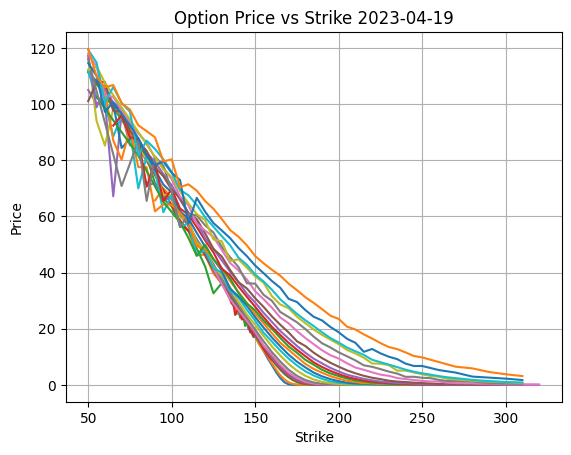

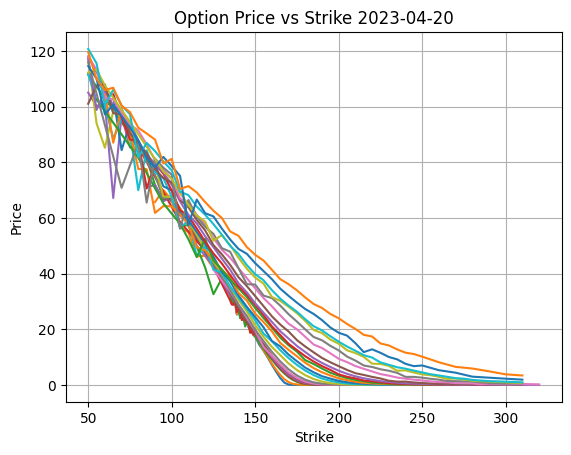

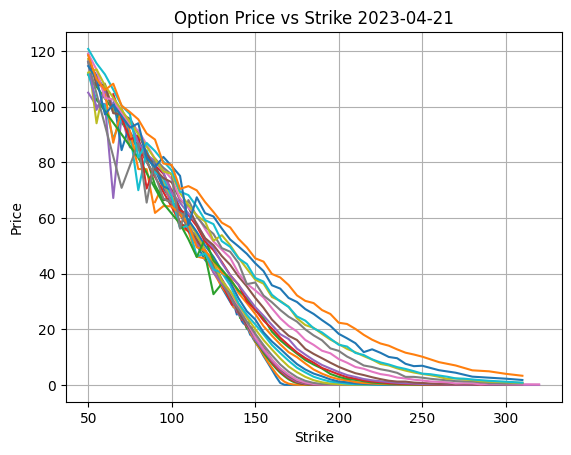

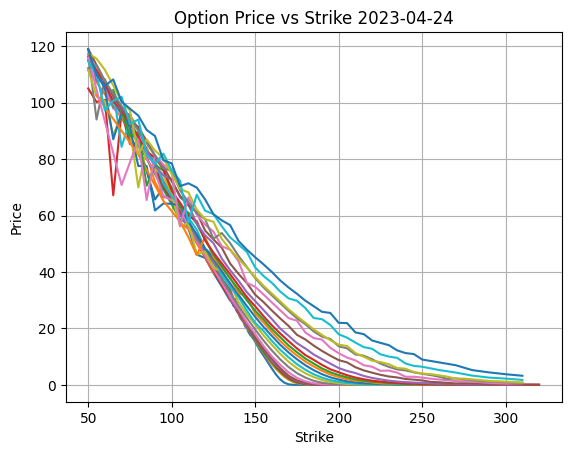

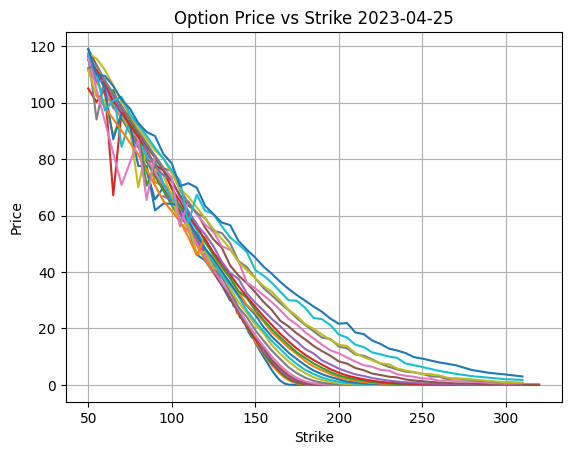

In [39]:
#Let's plot the option price vs strike for a few different dates and times to see if there is a pattern, guassian?

# Create the plot as a line graph for a few different dates and times
sample_days = df.index.levels[0][0:5]
for x in sample_days:
    sampleDayDf = df.loc[x]
    expiries = sampleDayDf['expiryDate'].unique()
    min_timestamp = sampleDayDf['timestamp'].min()
    sampleDayDf = sampleDayDf[sampleDayDf['timestamp'] == min_timestamp]
    # Create a line plot for each expiry date
    for expiry_date in expiries:
        subset = sampleDayDf[sampleDayDf['expiryDate'] == expiry_date]
        plt.plot(subset['strike'], subset['lastPrice'], label=str(expiry_date.date()))

    # Add a legend
    plt.xlabel('Strike')
    plt.ylabel('Price')
    plt.title('Option Price vs Strike' + ' ' + str(x))
    plt.grid(True)

    # Display the plot
    plt.show()

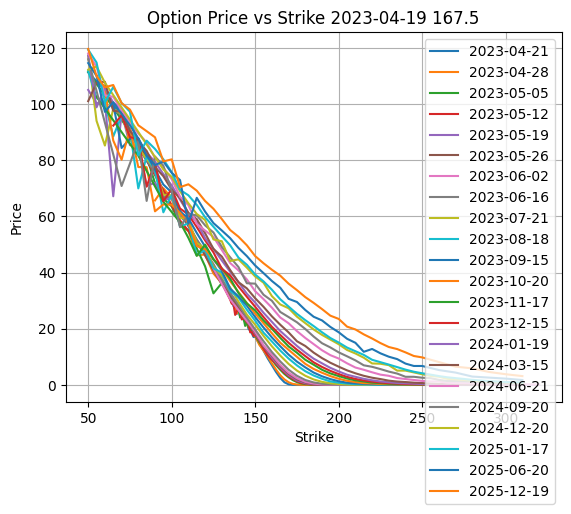

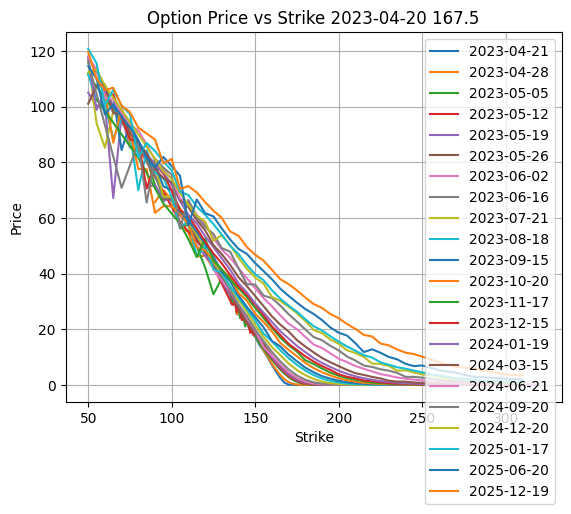

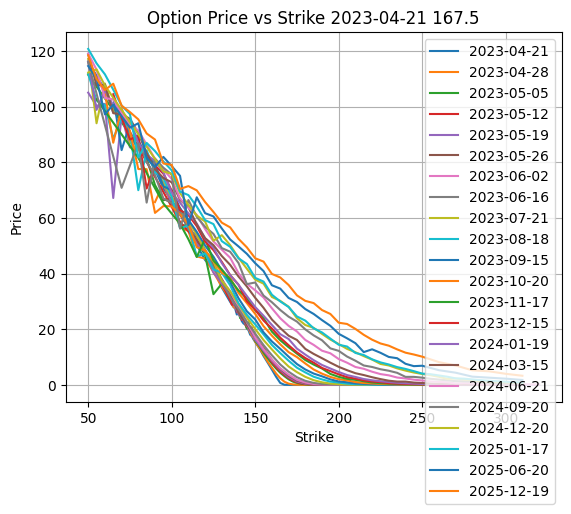

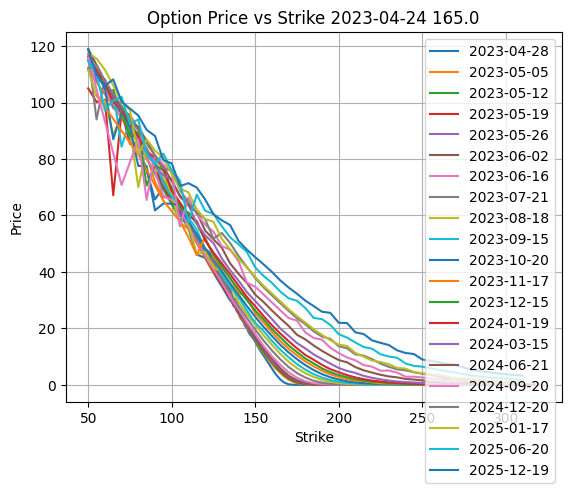

In [ ]:
# Let's plot the option price vs the difference of the strike from the opening stock price for a few different dates and times to see if there is a pattern, guassian?

# Create the plot as a line graph for a few different dates and times
sample_days = df.index.levels[0][0:5]
for x in sample_days:
    # Get the opening stock price for the day
    open_price = [option for option in in_the_money_strike_at_open if x in option][0][1]
    sampleDayDf = df.loc[x]
    # Get list of unique expiry dates
    expiries = sampleDayDf['expiryDate'].unique()
    # Get the first timestamp of the day so we can filter the dataframe to only include the first sample of the day
    min_timestamp = sampleDayDf['timestamp'].min()
    sampleDayDf = sampleDayDf[sampleDayDf['timestamp'] == min_timestamp]
    # Create a line plot for each expiry date
    for expiry_date in expiries:
        subset = sampleDayDf[sampleDayDf['expiryDate'] == expiry_date]
        plt.plot(open_price - subset['strike'], subset['lastPrice'], label=str(expiry_date.date()))

    # Add a legend etc
    plt.legend()
    plt.xlabel('Strike')
    plt.ylabel('Price')
    plt.title('Option Price vs Strike ' + str(x) + ' opening price ' + str(open_price))
    plt.grid(True)

    # Display the plot
    plt.show()

In [ ]:


# Select the ten options adjacent to the strike price at the open
for x in in_the_money_strike_at_open:
    print(x)

 
# Calculate the 90th percentile of volume for each day
volume_threshold = df.groupby(level=0)['volume'].quantile(0.9)

# For each day, select the options with volume greater than or equal to the threshold
top_volume_options = df[df.groupby('sample_date')['volume'].transform(lambda x: x >= volume_threshold[x.name])]

# Sort the DataFrame by sample_date and timestamp in descending order
top_volume_options.sort_values(['sample_date', 'timestamp'], ascending=[True, False], inplace=True)

# Group the options by their contract symbol, and calculate the average and standard deviation of the price changes
grouped = top_volume_options.groupby('contractSymbol')
mean_changes = grouped['change'].mean()
std_changes = grouped['change'].std()

# Flag any options whose price change is more than two standard deviations away from the mean
threshold = 2 * std_changes
flagged = (df['change'] - mean_changes[df['expiryDate']].values) > threshold[df['expiryDate']].values

# # Create a scatter plot of the price changes, highlighting the flagged options
# fig, ax = plt.subplots()
# ax.scatter(df['expiryDate'], df['change'], alpha=0.5)
# ax.scatter(df.loc[flagged, 'expiryDate'], df.loc[flagged, 'change'], c='red')
# ax.set_xlabel('Expiration Date')
# ax.set_ylabel('Price Change')
# ax.set_title('Flagged Options')
# plt.show()


In [ ]:
# Group the options by their expiration date, and calculate the mean volume for each expiration date
grouped = df.groupby('expiryDate')['volume'].mean()

# Sort the expiration dates by volume in descending order, and select the top 3 expiration dates
top3 = grouped.sort_values(ascending=False).head(3)

# Filter the data frame to only include options with the top 3 expiration dates
df_top3 = df[df['expiryDate'].isin(top3.index)]

# Group the top 3 expiration dates by their expiration date, and calculate the average and standard deviation of the price changes
grouped_top3 = df_top3.groupby('expiryDate')
mean_changes = grouped_top3['change'].mean()
std_changes = grouped_top3['change'].std()

# Flag any options whose price change is more than two standard deviations away from the mean
threshold = 2 * std_changes
flagged = (df_top3['change'] - mean_changes[df_top3['expiryDate']].values) > threshold[df_top3['expiryDate']].values

# Create a scatter plot of the price changes for the top 3 expiration dates, highlighting the flagged options
fig, ax = plt.subplots(figsize=(15, 7.5))
for i, (name, group) in enumerate(df_top3.groupby('expiryDate')):
    ax.scatter(group['timestamp'], group['change'], alpha=0.5, label=name if i == 0 else None)
ax.scatter(df_top3.loc[flagged, 'timestamp'], df_top3.loc[flagged, 'change'], c='red')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price Change')
ax.set_title('Flagged Options (Top 3 Expiration Dates by Volume)')
ax.legend()
plt.show()
